In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,datasets
from tqdm.notebook import tqdm
import torchvision
from torch import nn
import os
import pickle
import sys
from argparse import ArgumentParser

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from torch.nn import functional as fnn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from utils import NUM_PTS, CROP_SIZE
from utils import ScaleMinSideToSize, CropCenter, TransformByKeys
from utils import ThousandLandmarksDataset
from utils import restore_landmarks_batch, create_submission
import cv2
from torch.utils import data
import albumentations as A
from albumentations.pytorch import ToTensor


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:

TRAIN_SIZE = 0.8
NUM_PTS = 971
CROP_SIZE = 128
SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"


In [4]:
PATH_TRAIN='data_clean'

In [5]:


class ScaleMinSideToSize(object):
    def __init__(self, size=(CROP_SIZE, CROP_SIZE), elem_name='image'):
        # self.size = torch.tensor(size, dtype=torch.float)
        self.size = np.asarray(size, dtype=np.float)
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, _ = sample[self.elem_name].shape
        if h > w:
            f = self.size[0] / w
        else:
            f = self.size[1] / h

        sample[self.elem_name] = cv2.resize(sample[self.elem_name], None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
        sample["scale_coef"] = f

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2).float()
            landmarks = landmarks * f
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class CropCenter(object):
    def __init__(self, size=128, elem_name='image'):
        self.size = size
        self.elem_name = elem_name

    def __call__(self, sample):
        img = sample[self.elem_name]
        h, w, _ = img.shape
        margin_h = (h - self.size) // 2
        margin_w = (w - self.size) // 2
        sample[self.elem_name] = img[margin_h:margin_h + self.size, margin_w:margin_w + self.size]
        sample["crop_margin_x"] = margin_w
        sample["crop_margin_y"] = margin_h

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2)
            landmarks -= torch.tensor((margin_w, margin_h), dtype=landmarks.dtype)[None, :]
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class TransformByKeys(object):
    def __init__(self, transform, names):
        self.transform = transform
        self.names = set(names)

    def __call__(self, sample):
        for name in self.names:
            if name in sample:
                sample[name] = self.transform(sample[name])

        return sample


In [6]:
from PIL import Image

In [7]:
class MyAssDataset(data.Dataset):
    def __init__(self,images_paths,landmarks_path, transform):
        super(MyAssDataset, self).__init__()
        
        landmark_file_name = landmarks_path
        

        self.image_paths = images_paths
        self.image_names = [os.path.split(path)[-1] for path in self.image_paths]
        self.landmarks=[]
        self.landmark_file = pd.read_csv(landmarks_path,sep='\t',index_col=['file_name'])

        with open(landmark_file_name, "rt") as fp:
            num_lines = sum(1 for line in fp)
        num_lines -= 1  # header

        for image_name in tqdm(self.image_names):
            elements=self.landmark_file.loc[image_name].values
                
                
                    
            landmarks = list(map(np.int, elements))
            landmarks = np.array(landmarks, dtype=np.int).reshape((len(landmarks) // 2, 2))
            self.landmarks.append(landmarks)   
                
        self.landmarks = torch.as_tensor(self.landmarks)
        self.transform = transform
        
        
        self.init_preprocessing=transforms.Compose([
                                        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
                                        CropCenter(CROP_SIZE)])

    def clip(self,x):
        return min(max(x,0),CROP_SIZE-1)
    
    
    def init_preprocessing(self,sample):
        return self.init_preprocessing(sample)
            
            
    def __getitem__(self, idx):
        sample = {}
        
        landmarks = self.landmarks[idx]
        sample["landmarks"] = landmarks

        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample["image"] = image
            
        sample = self.init_preprocessing(sample)

            
        if self.transform is not None:
            sample['landmarks'] = np.array([self.clip(x) for x in sample['landmarks']  ])
            
            transformed = self.transform(image=sample['image'],keypoints=sample['landmarks'].reshape(-1,2))
            
            sample['landmarks'] = np.array(transformed['keypoints']).flatten()
            sample['image']  = transformed['image']
            
            sample['landmarks']= torch.tensor(sample['landmarks']).float()/128
            sample['image'] = sample['image']
            
            sample.pop('keypoints', None)
            
      
        
        

        
        return sample

    def __len__(self):
        return len(self.image_names)

In [8]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)

In [9]:
train_transform = A.Compose([
        
#         A.HorizontalFlip(p=0.5),
    A.Rotate(p=1,limit=30),
# #         A.OneOf([
# #             A.HueSaturationValue(p=0.5), 
# #             A.RGBShift(p=0.7)
# #         ], p=1),                          
#         A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]),
    A.pytorch.transforms.ToTensorV2(),
    
    
    
    ], 
    keypoint_params=A.KeypointParams(format='xy',remove_invisible=False),
)

In [10]:
val_transform = A.Compose([
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]),
    A.pytorch.transforms.ToTensorV2(),

    ], 
    keypoint_params=A.KeypointParams(format='xy',remove_invisible=False),
)

In [11]:
all_image_paths = [os.path.join(PATH_TRAIN,'images',name) for name in os.listdir(os.path.join(PATH_TRAIN,'images'))]

In [12]:
train_images,val_images=train_test_split(all_image_paths,test_size=0.33)

In [13]:
train_dataset  = MyAssDataset(train_images,os.path.join(PATH_TRAIN, 'landmarks.csv'),transform=train_transform)

In [14]:
train_dataset[3]['landmarks']

tensor([0.5989, 0.8935, 0.5921,  ..., 0.4311, 0.6477, 0.3688])

In [15]:
# i=13

In [16]:
# sample = {}
        
# landmarks = train_dataset.landmarks[i]
# sample["landmarks"] = torch.clone(landmarks)

# image = cv2.imread(train_dataset.image_paths[i])
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# sample["image"] = image


In [17]:
# tr = train_transform(image=sample['image'],keypoints=sample['landmarks'].reshape(-1,2))

In [18]:
# tr

In [19]:
# tr['image'].shape

In [20]:
# show_landmarks(tr['image'],np.array(tr['keypoints']))

In [21]:
# show_landmarks(sample['image'].permute(1,2,0),sample['landmarks'].reshape(-1,2))

In [22]:
t = train_dataset[3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


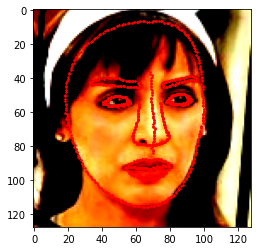

In [23]:
show_landmarks(t['image'].permute(1,2,0),t['landmarks'].reshape(-1,2)*128)

In [24]:
# train_transform = A.Compose([
        
#         A.HorizontalFlip(p=0.5),
#     A.Rotate(p=0.6),
# #         A.OneOf([
# #             A.HueSaturationValue(p=0.5), 
# #             A.RGBShift(p=0.7)
# #         ], p=1),                          
# #         A.RandomBrightnessContrast(p=0.5),
#     A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
#     ToTensor()
    
#     ], 
#     keypoint_params=A.KeypointParams(format='xy'),
# )

In [25]:
val_dataset = MyAssDataset(val_images,os.path.join(PATH_TRAIN, 'landmarks.csv'),transform=val_transform)

In [26]:
b = val_dataset[40]

In [27]:
b['image'].shape

torch.Size([3, 128, 128])

In [28]:
b

{'landmarks': tensor([0.4220, 0.8923, 0.4128,  ..., 0.3052, 0.7523, 0.4245]),
 'image': tensor([[[-2.0000, -2.0000, -1.9843,  ..., -1.9216, -1.9216, -1.9216],
          [-2.0000, -1.9843, -1.9843,  ..., -1.9216, -1.9216, -1.9216],
          [-2.0000, -1.9686, -2.0000,  ..., -1.9216, -1.9216, -1.9216],
          ...,
          [-1.9843, -2.0000, -1.9843,  ...,  0.9961,  1.0118,  0.9961],
          [-2.0000, -2.0000, -1.9686,  ...,  0.9490,  0.9647,  0.9961],
          [-2.0000, -1.9843, -1.9843,  ...,  0.9176,  0.9647,  0.9961]],
 
         [[-2.0000, -2.0000, -2.0000,  ..., -2.0000, -2.0000, -2.0000],
          [-2.0000, -1.9843, -2.0000,  ..., -1.9843, -1.9843, -1.9843],
          [-2.0000, -1.9686, -2.0000,  ..., -1.9843, -1.9843, -1.9843],
          ...,
          [-1.9843, -2.0000, -2.0000,  ...,  0.9333,  0.9490,  0.9333],
          [-1.9843, -2.0000, -1.9843,  ...,  0.8863,  0.9020,  0.9333],
          [-2.0000, -1.9843, -2.0000,  ...,  0.8549,  0.9020,  0.9333]],
 
         [[-2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


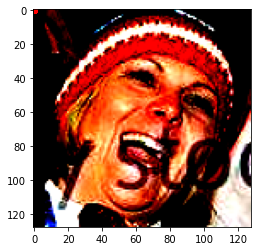

In [29]:
show_landmarks(b['image'].permute(1,2,0), b['landmarks'].reshape(-1,2))
   

In [30]:

class ThousandLandmarksDataset(data.Dataset):
    def __init__(self, root, transforms, split="train"):
        super(ThousandLandmarksDataset, self).__init__()
        self.root = root
        landmark_file_name = os.path.join(root, 'landmarks.csv') if split != "test" \
            else os.path.join(root, "test_points.csv")
        images_root = os.path.join(root, "images")

        self.image_names = []
        self.landmarks = []

        with open(landmark_file_name, "rt") as fp:
            num_lines = sum(1 for line in fp)
        num_lines -= 1  # header

        with open(landmark_file_name, "rt") as fp:
            for i, line in tqdm.tqdm(enumerate(fp), total=num_lines + 1):
                if i == 0:
                    continue  # skip header
                if split == "train" and i == int(TRAIN_SIZE * num_lines):
                    break  # reached end of train part of data
                elif split == "val" and i < int(TRAIN_SIZE * num_lines):
                    continue  # has not reached start of val part of data
                elements = line.strip().split("\t")
                image_name = os.path.join(images_root, elements[0])
                self.image_names.append(image_name)

                if split in ("train", "val"):
                    landmarks = list(map(np.int, elements[1:]))
                    landmarks = np.array(landmarks, dtype=np.int).reshape((len(landmarks) // 2, 2))
                    self.landmarks.append(landmarks)

        if split in ("train", "val"):
            self.landmarks = torch.as_tensor(self.landmarks)
        else:
            self.landmarks = None

        self.transforms = transforms

    def __getitem__(self, idx):
        sample = {}
        if self.landmarks is not None:
            landmarks = self.landmarks[idx]
            sample["landmarks"] = landmarks

        image = cv2.imread(self.image_names[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample["image"] = image

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

    def __len__(self):
        return len(self.image_names)


def restore_landmarks(landmarks, f, margins):
    dx, dy = margins
    landmarks[:, 0] += dx
    landmarks[:, 1] += dy
    landmarks /= f
    return landmarks


def restore_landmarks_batch(landmarks, fs, margins_x, margins_y):
    landmarks[:, :, 0] += margins_x[:, None]
    landmarks[:, :, 1] += margins_y[:, None]
    landmarks /= fs[:, None, None]
    return landmarks


In [31]:

def train(model, loader, loss_fn, optimizer, device,scheduler):
    model.train()
    train_loss = []
    for batch in tqdm(loader, total=len(loader), desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    return np.mean(train_loss)


def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)


def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [32]:

train_dataloader = DataLoader(train_dataset, batch_size=8, num_workers=6, pin_memory=True,
                              shuffle=True, drop_last=True)

val_dataloader = DataLoader(val_dataset, batch_size=64, num_workers=4, pin_memory=True,
                            shuffle=False, drop_last=False)

In [33]:

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [34]:
device

device(type='cuda', index=0)

In [35]:
# model = torchvision.models.mobilenet_v2(pretrained=True)
model = torchvision.models.wide_resnet50_2(pretrained=True)

In [36]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [37]:

model.requires_grad_(False)

model.fc = nn.Linear(2048,971*2,bias=True)
model.fc.requires_grad_(True)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [38]:

optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

loss_fn = fnn.mse_loss
EPOCHS=100
NUM_PREFIT_EPOCHS=2

In [39]:
PATH='contest01_data'
EXP_NAME='wide_resnet'

In [ ]:
os.makedirs("runs", exist_ok=True)
best_val_loss = np.inf

for epoch in range(EPOCHS):
    if epoch==NUM_PREFIT_EPOCHS:
        model.requires_grad_(True)
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device,scheduler)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join("runs", f"{EXP_NAME}_best.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)



Epoch # 0:	train loss: 0.016	val loss: 0.014


In [43]:

class ThousandLandmarksDataset(data.Dataset):
    def __init__(self, root, transforms, split="train"):
        super(ThousandLandmarksDataset, self).__init__()
        self.root = root
        landmark_file_name = os.path.join(root, 'landmarks.csv') if split != "test" \
            else os.path.join(root, "test_points.csv")
        images_root = os.path.join(root, "images")

        self.image_names = []
        self.landmarks = []

        with open(landmark_file_name, "rt") as fp:
            num_lines = sum(1 for line in fp)
        num_lines -= 1  # header

        with open(landmark_file_name, "rt") as fp:
            for i, line in tqdm(enumerate(fp), total=num_lines + 1):
                if i == 0:
                    continue  # skip header
                if split == "train" and i == int(TRAIN_SIZE * num_lines):
                    break  # reached end of train part of data
                elif split == "val" and i < int(TRAIN_SIZE * num_lines):
                    continue  # has not reached start of val part of data
                elements = line.strip().split("\t")
                image_name = os.path.join(images_root, elements[0])
                self.image_names.append(image_name)

                if split in ("train", "val"):
                    landmarks = list(map(np.int, elements[1:]))
                    landmarks = np.array(landmarks, dtype=np.int).reshape((len(landmarks) // 2, 2))
                    self.landmarks.append(landmarks)

        if split in ("train", "val"):
            self.landmarks = torch.as_tensor(self.landmarks)
        else:
            self.landmarks = None

        self.transforms = transforms

    def __getitem__(self, idx):
        sample = {}
        if self.landmarks is not None:
            landmarks = self.landmarks[idx]
            sample["landmarks"] = landmarks

        image = cv2.imread(self.image_names[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample["image"] = image

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

    def __len__(self):
        return len(self.image_names)

In [44]:
val_preprocessing = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),
     
])

In [60]:

def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()*128
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [61]:
test_dataset = ThousandLandmarksDataset(os.path.join('data_dirty', "test"), val_preprocessing, split="test")
test_dataloader = DataLoader(test_dataset, batch_size=128, num_workers=4, pin_memory=True,
                             shuffle=False, drop_last=False)

with open(os.path.join("runs", f"{EXP_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

test_predictions = predict(model, test_dataloader, device)
with open(os.path.join("runs", f"{EXP_NAME}_test_predictions.pkl"), "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                 "landmarks": test_predictions}, fp)


In [62]:
v= model(val_dataset[5]['image'].unsqueeze(0).to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


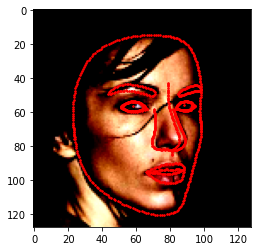

In [67]:
show_landmarks(val_dataset[5]['image'].permute(1,2,0).cpu().detach().numpy(),v.reshape(-1,2).cpu().detach().numpy()*128)

In [54]:
buf = train_dataset[1]['image']

In [55]:
tran = model(buf.unsqueeze(0).to(device))

In [56]:
tran

tensor([[ 56.4268, 114.8502,  55.3968,  ...,  51.9756,  65.0040,  48.5218]],
       device='cuda:0', grad_fn=<AddmmBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


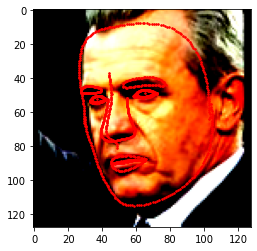

In [57]:
show_landmarks(buf.permute(1,2,0).cpu().detach().numpy(),tran.reshape(-1,2).cpu().detach().numpy())

In [51]:
p = model(test_dataset[0]['image'].unsqueeze(0).to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


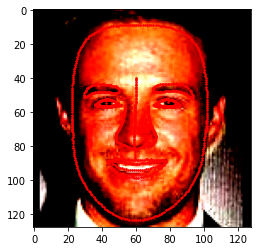

In [53]:
show_landmarks(test_dataset[0]['image'].permute(1,2,0).cpu().detach().numpy(),p.reshape(-1,2).cpu().detach().numpy()*128)

In [68]:

create_submission('data_dirty', test_predictions, os.path.join("runs", f"{EXP_NAME}_submit_1.csv"))


In [ ]:

def train(model, loader, loss_fn, optimizer, device,scheduler):
    model.train()
    train_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    return np.mean(train_loss)


def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)


def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [ ]:
```
transform = A.Compose([
    A.RandomCrop(width=330, height=330),
    A.RandomBrightnessContrast(p=0.2),
    ...
], keypoint_params=A.KeypointParams(format='xy'))


# в функции train
for landmarks_batch, image_batch : dataset(не помню что тут): # возвращает данные после нормализации кропа и ресайза до 128x128

   # тут сдвиги и повороты и флипы
   landmarks_batch_transformed, image_batch_transformed =  transform(landmarks_batch, image_batch)
   
   landmarks_batch_predicted = model(image_batch_transformed)

   loss_fn(landmarks_batch_predicted, image_batch_transformed)
   ....

# в функции val
for landmarks_batch, image_batch : dataset(не помню что тут): # возвращает данные после нормализации кропа и ресайза до 128x128
   landmarks_batch_predicted = model(image_batch)
   loss_fn(landmarks_batch_predicted, landmarks_batch)
   ....


# в функции test
for image_batch : test_dataset(не помню что тут): # возвращает данные после нормализации кропа и ресайза до 128x128
   landmarks_batch_predicted = model(image_batch)